# broken-machine challange - quite challangeable

As the 1 in ytrain is 30%, so the accuracy of 0.7 is useless.

Traditional Rf, LogisticRegression and GussianNB are useless as the AUC is 0.5.

GBM, LightGBM and Catboost are good, XGBoost need more work to improve.

The model building is quite time comsuming, and Kaggle has 60 min limits, so marked the training parts. Just upload the trained models for ensemble.

Log data processing is not used.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [12]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgb

In [13]:
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load


##EDA part

In [14]:
file_path = '../input/the-broken-machine/'
model_path = '../input/broke-machine-model/'
# file_path = './the-broken-machine/'

In [15]:
xtrain = pd.read_csv(file_path + 'xtrain.csv')
ytrain = pd.read_csv(file_path + 'ytrain.csv')
print(xtrain.shape)
print(ytrain.shape)
xtrain.head()

(900000, 58)
(900000, 1)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,-42.822536,NaN,12.0,NaN,1.0,2.0,24.0,-45.025510,NaN,1.0,3.910841,20.037239,NaN,-86.651101,17.0,-11.405955,15.0,4.0,-20.011925,27.271964,1.0,6.0,NaN,6.0,-30.662868,14.0,12.0,42.059872,1.0,2.0,5.0,3.0,1.242426,83.114610,-52.682517,6.0,1.397560,13.858564,5.010444,-1.035085,3.828019,-0.031808,28.884589,1.0,12.0,-41.656958,0.0,4.0,17.871210,4.0,15.0,21.863365,-13.349394,-2.215086,-5.137377,20.904186,53.939262,-17.328346
1,-13.478816,13.0,12.0,75.132502,0.0,2.0,24.0,-49.213545,7.0,0.0,103.028552,-44.603587,-75.457614,-109.772769,16.0,-7.386768,18.0,3.0,-52.541216,-23.053329,NaN,4.0,2.0,6.0,22.561123,14.0,11.0,63.131398,5.0,0.0,5.0,5.0,22.215217,110.620332,-40.950731,4.0,0.846452,3.514293,4.839021,-39.124343,-69.000123,6.253618,24.671585,0.0,10.0,-55.085782,NaN,5.0,21.511019,2.0,13.0,-2.880103,21.739125,5.464161,-30.347612,23.304507,47.746225,-47.305489
2,51.702721,13.0,12.0,63.459270,0.0,3.0,24.0,-58.777043,8.0,0.0,14.850524,53.516062,107.018098,-118.540065,17.0,-15.714059,17.0,3.0,27.369359,10.830127,NaN,1.0,2.0,5.0,6.025768,16.0,16.0,50.964614,3.0,1.0,3.0,3.0,19.954300,106.354195,NaN,5.0,1.574550,105.726958,19.599097,-3.289164,37.006898,7.935197,30.661709,2.0,12.0,-36.352728,1.0,NaN,NaN,3.0,16.0,21.851623,NaN,7.471764,-12.348314,34.406243,34.479515,-33.326172
3,NaN,12.0,13.0,-15.492561,1.0,1.0,23.0,0.624258,9.0,0.0,60.256580,32.640212,17.508750,-62.551522,NaN,-3.518383,20.0,3.0,-36.065397,-20.201555,6.0,7.0,0.0,NaN,2.248286,NaN,15.0,49.726230,4.0,1.0,3.0,3.0,6.221229,156.324453,NaN,4.0,2.032347,87.030045,3.688423,-29.169872,-107.670733,1.650324,32.429857,0.0,NaN,-83.484587,1.0,5.0,16.964848,2.0,15.0,-25.128119,-26.858262,54.203501,10.341217,29.080753,40.235855,-35.835956
4,7.633273,NaN,13.0,59.862681,0.0,3.0,NaN,-61.395319,NaN,0.0,62.568909,14.070520,68.503324,-109.179454,17.0,-12.600967,18.0,1.0,27.338942,8.290927,6.0,4.0,3.0,7.0,14.059204,13.0,10.0,55.275521,3.0,0.0,1.0,6.0,13.406162,35.263210,-39.812185,4.0,1.571146,64.538871,NaN,-19.693179,-73.401922,8.437617,28.678940,1.0,10.0,-67.043181,0.0,4.0,8.467076,4.0,14.0,30.610006,-15.663721,38.323843,-65.561821,33.965883,50.245794,-44.018245


In [16]:
print("1 ratio is：",ytrain[ytrain==1].count()/len(ytrain))
#那么accuracy小于70%是没有意义的

1 ratio is： x    0.306733
dtype: float64


In [17]:
#check data
pd.set_option('display.max_columns', None)
xtrain.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
count,820529.000000,808921.000000,831550.000000,828051.000000,819375.000000,796632.000000,791582.000000,796405.000000,840044.000000,794046.000000,792089.000000,822082.000000,801824.000000,822891.000000,785297.000000,822112.000000,804309.000000,807722.000000,857586.000000,829599.000000,803971.000000,813872.000000,768612.000000,823381.000000,809400.000000,823554.000000,792591.000000,812095.000000,786992.000000,821643.000000,827947.000000,820935.000000,815735.000000,815943.000000,800966.000000,815103.000000,831796.000000,816783.000000,812253.000000,786253.000000,832848.000000,844694.000000,820059.000000,794462.000000,806247.000000,820501.000000,813624.000000,807994.000000,803958.000000,836761.000000,798606.000000,843544.000000,814017.000000,812818.000000,800856.000000,812926.000000,835366.000000,786115.000000
mean,11.012513,12.329729,11.344055,25.406132,0.313465,2.180648,23.222268,-46.304667,7.901558,0.269151,18.861322,-0.041151,34.218568,-75.809123,17.017246,-10.157221,16.487517,3.262584,-12.330677,-0.459010,3.996705,4.528458,1.943161,5.242677,-4.216974,13.804168,12.944043,51.502419,3.087400,0.480919,3.703203,3.679392,12.461969,94.034313,-40.156848,3.568553,13.057739,58.122214,-6.123216,-16.370387,-16.136563,1.004033,33.459364,0.873484,10.854306,-22.304327,0.180856,4.151400,20.596154,2.982181,14.680950,24.042950,-19.295371,16.461962,-25.783931,26.158484,38.320750,-37.013222
std,99.986889,0.796650,1.662548,20.636810,0.536960,0.771303,0.867651,19.875120,1.286734,0.443519,49.614572,57.759273,48.851803,36.291627,1.593982,7.029631,1.702498,1.563738,47.748428,16.883979,2.000666,1.679393,0.827062,1.903169,30.479622,2.067500,2.376194,8.740448,1.592139,0.658498,0.980956,1.474963,9.489320,33.014736,26.893601,1.662087,703.427308,47.026958,14.919673,18.117609,49.942193,3.000944,9.100382,0.787409,1.018797,35.154747,0.384899,1.679597,6.409154,1.097207,2.301128,29.146244,47.647342,45.131263,23.565330,8.508795,5.995944,15.246010
min,-480.088690,7.000000,3.000000,-72.310070,0.000000,0.000000,17.000000,-138.181159,1.000000,0.000000,-209.150651,-99.999949,-189.175571,-249.445847,8.000000,-42.982325,7.000000,0.000000,-269.369596,-83.560468,0.000000,0.000000,0.000000,0.000000,-146.801871,3.000000,2.000000,8.707719,0.000000,0.000000,0.000000,0.000000,-33.598865,-72.840032,-169.554805,0.000000,0.001055,-182.790369,-77.903990,-107.536168,-242.543540,-13.849135,-9.012487,0.000000,4.000000,-201.520935,0.000000,0.000000,-11.358178,0.000000,4.000000,-115.421307,-246.217734,-197.419313,-136.146509,-14.899675,9.648201,-112.352665
25%,-56.357813,12.000000,10.000000,11.492726,0.000000,2.000000,23.000000,-59.736287,7.000000,0.000000,-14.634677,-50.112412,1.308361,-100.329038,16.000000,-14.901519,15.000000,2.000000,-44.549383,-11.861807,3.000000,3.000000,1.000000,4.000000,-24.785978,12.000000,11.000000,45.605898,2.000000,0.000000,3.000000,3.000000,6.067196,71.757228,-58.322774,2.000000,0.539710,26.477823,-16.203234,-28.605769,-49.831652,-1.017484,27.318588,0.000000,10.000000,-46.089043,0.000000,3.000000,16.278806,2.000000,13.000000,4.395491,-51.462848,-13.974363,-41.718505,20.427519,34.264541,-47.312376
50%,11.029669,13.000000,11.000000,25.421574,0.000000,2.000000,23.000000,-46.305721,8.000000,0.000000,18.794859,-0.066081,34.142487,-75.824085,17.000000,-10.154716,17.000000,3.000000,-12.304059,-0.451381,4.000000,4.000000,2.000000,5.000000,-4.201808,14.000000,13.000000,51.499438,3.000000,0.000000,4.000000,4.000000,12.453091,94.100997,-40.148911,3.000000,1.251148,58.133416,-6.130804,-16.371175,-16.128463,1.010162,33.467780,1.000000,11.000000,-22.276223,0.000000,4.000000,20.605346,3.000000,15.000000,24.050412,-19.318562,16.460499,-25.779677,26.149082,38.316862,-36.990170
75%,78.379658,13.000000,13.000000,39.346755,1.000000,3.000000,24.000000,-32.910540,9.000000,1.000000,52.360987,49.931081,67.202304,-51

Text(0.5, 1.0, 'Percent missing data by feature')

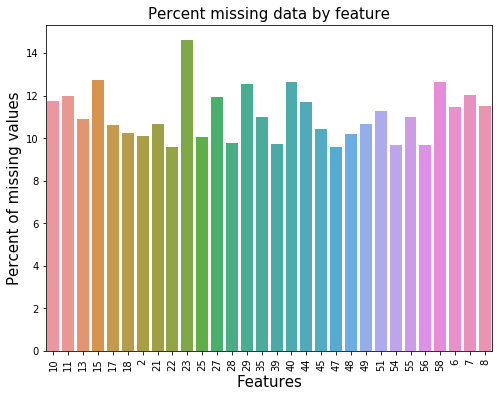

In [18]:
#Check missing data
all_data_na = (xtrain.isnull().sum() / len(xtrain)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [19]:
#EDA NA processing,lgb doesn't need na processing
for col in xtrain.columns:
    xtrain[col] = xtrain[col].fillna(xtrain[col].mode()[0])#用众数
xtrain.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
count,900000.000000,900000.00000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000
mean,-32.352269,12.39756,11.393943,17.594373,0.285383,2.159900,23.315957,-56.880162,7.908116,0.237464,-8.477566,-8.585745,9.849742,-90.685739,17.015048,-12.997979,16.542006,3.235661,-24.444064,-6.959483,3.890358,4.477886,1.951459,5.222018,-18.570520,13.820802,12.950721,47.322566,3.076426,0.439049,3.726964,3.707558,8.149395,78.448806,-54.395511,3.514921,12.068274,35.846633,-13.121602,-27.892425,-33.029542,0.091289,29.686872,0.888320,10.869483,-38.134928,0.163499,4.135922,17.186201,2.983433,14.716894,15.294512,-40.974777,-4.256480,-37.941472,22.186152,38.649826,-46.546591
std,168.910068,0.78185,1.607507,33.077854,0.520107,0.727942,0.852184,34.775717,1.243378,0.425529,87.479377,61.786787,83.523571,59.716452,1.488958,11.415670,1.617182,1.483544,71.689251,27.581024,1.915795,1.604564,0.764575,1.821616,51.730686,1.978498,2.229973,15.176900,1.489111,0.643622,0.944311,1.411607,16.175874,57.845387,47.784887,1.590458,676.257404,82.929610,25.578641,34.704771,76.468554,4.601772,14.881331,0.740921,0.965301,60.935965,0.369820,1.592092,11.577083,1.057967,2.169979,44.042883,80.640718,76.430115,41.086291,14.584661,5.896533,28.816355
min,-480.088690,7.00000,3.000000,-72.310070,0.000000,0.000000,17.000000,-138.181159,1.000000,0.000000,-209.150651,-99.999949,-189.175571,-249.445847,8.000000,-42.982325,7.000000,0.000000,-269.369596,-83.560468,0.000000,0.000000,0.000000,0.000000,-146.801871,3.000000,2.000000,8.707719,0.000000,0.000000,0.000000,0.000000,-33.598865,-72.840032,-169.554805,0.000000,0.001055,-182.790369,-77.903990,-107.536168,-242.543540,-13.849135,-9.012487,0.000000,4.000000,-201.520935,0.000000,0.000000,-11.358178,0.000000,4.000000,-115.421307,-246.217734,-197.419313,-136.146509,-14.899675,9.648201,-112.352665
25%,-81.556941,12.00000,10.000000,6.888838,0.000000,2.000000,23.000000,-66.684280,7.000000,0.000000,-32.971099,-64.353159,-14.651845,-109.089694,16.000000,-16.620388,16.000000,2.000000,-50.397995,-15.521853,3.000000,3.000000,2.000000,4.000000,-33.758087,13.000000,12.000000,43.123221,2.000000,0.000000,3.000000,3.000000,3.505148,62.872821,-67.252760,3.000000,0.421477,13.981093,-20.406861,-35.840037,-60.040167,-1.512564,25.030674,0.000000,10.000000,-54.878588,0.000000,3.000000,14.234201,2.000000,13.000000,-0.532367,-64.596465,-26.604268,-49.522752,18.027887,34.627694,-53.404316
50%,-1.108547,13.00000,12.000000,23.169244,0.000000,2.000000,24.000000,-49.566803,8.000000,0.000000,10.298210,-9.518766,26.665218,-80.116980,17.000000,-11.000547,17.000000,3.000000,-15.251352,-2.251834,4.000000,4.000000,2.000000,5.000000,-8.483830,14.000000,13.000000,50.312659,3.000000,0.000000,4.000000,4.000000,11.229190,89.806497,-44.334770,3.000000,1.094237,52.144621,-8.162934,-19.693802,-21.224451,0.761212,32.353628,1.000000,11.000000,-26.574056,0.000000,4.000000,19.643619,3.000000,15.000000,21.608292,-25.652576,10.310724,-29.465617,25.005533,38.901546,-39.788805
75%,70.966867,13.00000,12.000000,37.962973,1.000000,3.000000,24.000000,-34.871477,9.000000,0.000000,47.220517,45.223848,62.575965,

In [20]:
xtrain.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,-42.822536,13.0,12.0,-72.310070,1.0,2.0,24.0,-45.025510,8.0,1.0,3.910841,20.037239,-189.175571,-86.651101,17.0,-11.405955,15.0,4.0,-20.011925,27.271964,1.0,6.0,2.0,6.0,-30.662868,14.0,12.0,42.059872,1.0,2.0,5.0,3.0,1.242426,83.114610,-52.682517,6.0,1.397560,13.858564,5.010444,-1.035085,3.828019,-0.031808,28.884589,1.0,12.0,-41.656958,0.0,4.0,17.871210,4.0,15.0,21.863365,-13.349394,-2.215086,-5.137377,20.904186,53.939262,-17.328346
1,-13.478816,13.0,12.0,75.132502,0.0,2.0,24.0,-49.213545,7.0,0.0,103.028552,-44.603587,-75.457614,-109.772769,16.0,-7.386768,18.0,3.0,-52.541216,-23.053329,3.0,4.0,2.0,6.0,22.561123,14.0,11.0,63.131398,5.0,0.0,5.0,5.0,22.215217,110.620332,-40.950731,4.0,0.846452,3.514293,4.839021,-39.124343,-69.000123,6.253618,24.671585,0.0,10.0,-55.085782,0.0,5.0,21.511019,2.0,13.0,-2.880103,21.739125,5.464161,-30.347612,23.304507,47.746225,-47.305489
2,51.702721,13.0,12.0,63.459270,0.0,3.0,24.0,-58.777043,8.0,0.0,14.850524,53.516062,107.018098,-118.540065,17.0,-15.714059,17.0,3.0,27.369359,10.830127,3.0,1.0,2.0,5.0,6.025768,16.0,16.0,50.964614,3.0,1.0,3.0,3.0,19.954300,106.354195,-169.554805,5.0,1.574550,105.726958,19.599097,-3.289164,37.006898,7.935197,30.661709,2.0,12.0,-36.352728,1.0,4.0,-11.358178,3.0,16.0,21.851623,-246.217734,7.471764,-12.348314,34.406243,34.479515,-33.326172
3,-480.088690,12.0,13.0,-15.492561,1.0,1.0,23.0,0.624258,9.0,0.0,60.256580,32.640212,17.508750,-62.551522,17.0,-3.518383,20.0,3.0,-36.065397,-20.201555,6.0,7.0,0.0,5.0,2.248286,14.0,15.0,49.726230,4.0,1.0,3.0,3.0,6.221229,156.324453,-169.554805,4.0,2.032347,87.030045,3.688423,-29.169872,-107.670733,1.650324,32.429857,0.0,11.0,-83.484587,1.0,5.0,16.964848,2.0,15.0,-25.128119,-26.858262,54.203501,10.341217,29.080753,40.235855,-35.835956
4,7.633273,13.0,13.0,59.862681,0.0,3.0,24.0,-61.395319,8.0,0.0,62.568909,14.070520,68.503324,-109.179454,17.0,-12.600967,18.0,1.0,27.338942,8.290927,6.0,4.0,3.0,7.0,14.059204,13.0,10.0,55.275521,3.0,0.0,1.0,6.0,13.406162,35.263210,-39.812185,4.0,1.571146,64.538871,-77.903990,-19.693179,-73.401922,8.437617,28.678940,1.0,10.0,-67.043181,0.0,4.0,8.467076,4.0,14.0,30.610006,-15.663721,38.323843,-65.561821,33.965883,50.245794,-44.018245


In [21]:
# EDA skew
xtrain.skew(axis=0).sort_values(ascending=False)
#发现37数值异常

37    262.302807
47      1.819812
5       1.706227
30      1.353397
10      1.233927
21      0.667099
44      0.505496
29      0.454329
36      0.439097
18      0.390172
48      0.257956
22      0.244972
24      0.237942
32      0.067940
12      0.065799
27     -0.069231
57     -0.133575
51     -0.175974
50     -0.186020
26     -0.216883
3      -0.402522
23     -0.419464
15     -0.467046
9      -0.484705
17     -0.495398
6      -0.535379
31     -0.580391
45     -0.887433
11     -1.155277
8      -1.181826
13     -1.186588
55     -1.221602
58     -1.233154
7      -1.241583
25     -1.254063
40     -1.258061
2      -1.261904
41     -1.263255
35     -1.264954
43     -1.288668
54     -1.289975
16     -1.295708
53     -1.303188
39     -1.312938
56     -1.320144
49     -1.335219
4      -1.340678
33     -1.342095
28     -1.342330
14     -1.342744
1      -1.382681
52     -1.388590
34     -1.414569
20     -1.418820
38     -1.441804
46     -1.450448
42     -1.463688
19     -1.660776
dtype: float64

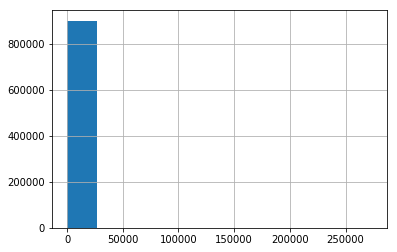

In [22]:
xtrain['37'].hist()

In [23]:
xtrain['37']=xtrain['37'].apply(lambda x:200 if x>100 else x) #处理37号


 mu = 5.39 and sigma = 20.60



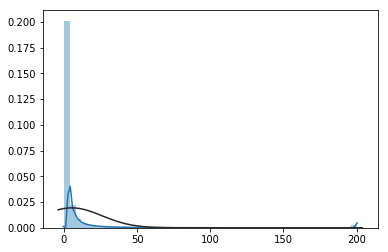

<Figure size 432x288 with 0 Axes>

In [24]:
#EDA No. 37
from scipy import stats
from scipy.stats import norm, skew #for some statistics
def check_skewness(col):
    sns.distplot(xtrain[col] , fit=norm);
    fig = plt.figure()
#     res = stats.probplot(xtrain[col], plot=plt) #probplot不能显示，如果是index整数就可显示
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(xtrain[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness(['37']) 

In [25]:
# check unique value
for i in xtrain.columns:
    print(i,": ",len(xtrain[i].unique()))

1 :  820529
2 :  7
3 :  13
4 :  828051
5 :  5
6 :  4
7 :  8
8 :  796405
9 :  10
10 :  2
11 :  792089
12 :  822004
13 :  801824
14 :  822891
15 :  13
16 :  822112
17 :  14
18 :  13
19 :  857586
20 :  829599
21 :  19
22 :  13
23 :  4
24 :  16
25 :  809400
26 :  18
27 :  22
28 :  812095
29 :  13
30 :  6
31 :  6
32 :  10
33 :  815735
34 :  815943
35 :  800966
36 :  14
37 :  823521
38 :  816783
39 :  812253
40 :  786253
41 :  832848
42 :  844694
43 :  820059
44 :  4
45 :  9
46 :  820501
47 :  2
48 :  14
49 :  803958
50 :  6
51 :  20
52 :  843544
53 :  814017
54 :  812818
55 :  800856
56 :  812926
57 :  835365
58 :  786115


[]

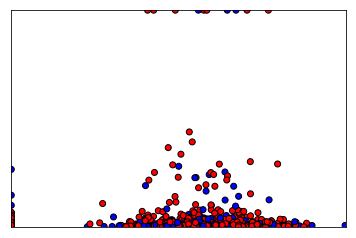

In [26]:
#Feature distribution
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
h = .2  # step size in the mesh

x_min, x_max = xtrain.iloc[0:1000, 33].min() - .5, xtrain.iloc[0:1000, 33].max() + .5
y_min, y_max = xtrain.iloc[0:1000, 36].min() - .5, xtrain.iloc[0:1000, 36].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot()
ax.scatter(xtrain.iloc[0:1000, 33], xtrain.iloc[0:1000, 36], c=list(ytrain.iloc[0:1000,0]),cmap=cm_bright,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

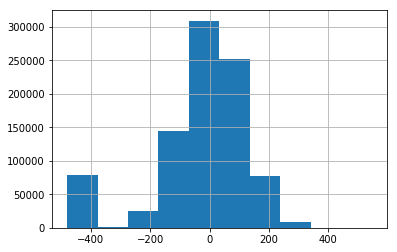

In [27]:
xtrain['1'].hist()

In [28]:
#corelation
corrmat = xtrain.corr()
corrmat

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
1,1.000000,0.000171,0.000950,2.233203e-03,0.001447,-0.000231,-0.000323,-0.001177,-0.001098,0.000494,0.000895,0.000449,-0.001307,-0.000239,-0.001295,-0.001533,-0.001746,-0.001028,-0.000674,0.000392,-0.001084,-0.000205,0.001204,-0.000762,-0.000305,-0.000644,-0.002717,-0.001003,-0.001789,-0.000841,0.001756,0.001241,0.001272,0.000013,-0.000208,-0.001104,0.000159,-0.001087,0.000803,-0.000219,0.001328,5.661361e-04,-0.000020,0.001209,-0.000460,0.000028,0.001234,-0.000077,0.000311,-0.000411,0.000036,0.000520,-0.000722,-0.000795,-0.000861,-0.000948,0.000451,-0.001293
2,0.000171,1.000000,-0.001441,1.466180e-03,-0.000490,0.000600,-0.001862,0.000360,-0.000910,-0.000604,0.001502,-0.001225,-0.000654,-0.000059,0.001276,-0.000974,0.001073,-0.001989,-0.001538,0.001187,0.002185,0.001218,-0.000817,-0.000292,-0.000593,-0.001859,0.001532,-0.000353,0.000989,-0.000851,-0.000213,0.000163,0.000695,0.001522,0.000865,0.001147,0.000462,0.000408,-0.001453,0.000819,0.000612,9.784430e-04,-0.000136,0.000647,0.001089,-0.000666,0.000355,-0.001185,0.002052,-0.000015,0.000055,0.000768,0.000252,0.000528,0.001493,0.000368,-0.001423,-0.000282
3,0.000950,-0.001441,1.000000,1.176361e-03,-0.000141,0.000254,-0.000604,0.000864,-0.000602,-0.000903,0.000584,0.000487,-0.000375,0.001958,-0.000310,0.000010,-0.000257,0.001227,-0.001274,0.001460,0.001527,-0.001876,0.000128,-0.000024,0.000315,-0.001296,0.000241,0.000414,0.002053,-0.000869,0.003393,-0.000378,-0.000726,-0.000032,-0.000702,-0.000355,0.000611,-0.000433,0.001807,0.000423,0.000375,7.499888e-04,-0.001000,0.000193,0.002377,0.002397,0.000306,0.000466,0.000323,0.000453,0.001898,-0.001808,0.000510,-0.000443,0.001068,0.000053,0.002494,-0.000595
4,0.002233,0.001466,0.001176,1.000000e+00,0.000853,0.000042,-0.001651,0.000603,0.000250,0.000355,0.000210,0.001325,-0.000381,0.000226,0.000232,-0.000203,0.001282,-0.000462,0.000090,0.000319,-0.003188,-0.001386,-0.001145,-0.000704,0.000037,0.000419,-0.000572,-0.000438,-0.001114,0.001143,0.001788,0.000735,-0.002346,-0.000773,-0.000246,0.000482,-0.001844,0.000467,-0.000095,0.000045,-0.002084,3.733806e-07,-0.000779,0.001197,0.002171,-0.001430,0.002649,-0.001375,0.000552,0.000107,-0.001386,0.001323,0.002133,-0.001179,0.001283,-0.000747,-0.001960,-0.000044
5,0.001447,-0.000490,-0.000141,8.528581e-04,1.000000,-0.000544,0.000562,0.000764,0.000806,0.001077,0.000498,-0.000898,-0.001412,-0.001514,0.001908,-0.000421,-0.000528,-0.001396,-0.001940,0.000302,0.000901,0.001277,0.000527,0.001080,-0.000793,0.000065,-0.000218,-0.000791,-0.002005,0.000500,0.001490,0.000427,0.001703,0.001390,0.000168,0.000845,-0.000307,-0.001405,0.000549,0.001797,0.000263,7.521536e-04,0.000409,-0.000221,0.000116,0.000633,-0.001131,-0.001089,-0.000602,0.000345,-0.000677,-0.001973,-0.000811,0.001181,0.000236,0.000163,-0.000045,0.000077
6,-0.000231,0.000600,0.000254,4.227014e-05,-0.000544,1.000000,-0.000733,-0.000883,-0.001324,0.000644,0.000007,-0.000633,-0.000371,0.001622,0.000080,0.000252,-0.001193,-0.000056,0.000652,0.001869,0.000892,-0.001030,0.000628,0.000007,-0.000891,-0.000308,0.001406,0.000892,0.000443,-0.002178,0.000744,0.000338,0.001763,-0.000263,0.001329,-0.000323,-0.000528,-0.001738,-0.001901,-0.000723,0.000395,-3.474330e-04,-0.000798,0.000830,0.000774,-0.000570,-0.000232,0.000276,-0.000554,-0.000883,0.000333,0.001765,-0.000980,-0.000254,0.000277,0.000320,0.000301,-0.000774
7,-0.000323,-0.001862,-0.000604,-1.651140e-03,0.000562,-0.000733,1.000000,0.001112,0.000439,-0.000437,0.000362,-0.000717,0.000664,0.000190,-0.000314,0.000629,-0.001821,0.000179,0.001230,0.000799,-0.000730,0.000758,-0.000073,0.000746,-0.002734,0.000826,-0.000034,-0.000343,0.002118,-0.001925,0.000969,-0.001039,0.000548,0.000804,-0.000831,-0.000707,0.000451,-0.000366,-0.000117,0.001353,0.001887,9.255782e-04,-0.000663,0.000194,-0.000812,0.001438,-0.000940,-0.002245,0.000196,0.000434,

In [29]:
corrmat[corrmat>0.01].count()
#No clear corelation

1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
53    1
54    1
55    1
56    1
57    1
58    1
dtype: int64

In [30]:
# plt.figure(figsize=(10,10))
# g = sns.heatmap(train_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.check_cv.html#sklearn.model_selection.check_cv
# from sklearn.model_selection import check_cv
# cv = check_cv(3, xtrain, ytrain, classifier=True)

No clear patten for the scattering

## Training part

In [31]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X_train, X_test, y_train, y_test=train_test_split(xtrain[0:-10000],ytrain[0:-10000], test_size=0.2, random_state=3)
# gc.collect()  
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(712000, 58)
(178000, 58)
(712000, 1)


In [32]:
X_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
248267,77.429917,13.0,12.0,16.965322,1.0,1.0,22.0,-25.325592,9.0,0.0,30.372175,23.172436,-189.175571,-108.119863,15.0,-5.704539,19.0,5.0,-48.950463,17.100496,5.0,5.0,3.0,3.0,-49.528172,15.0,16.0,59.772857,4.0,1.0,4.0,1.0,18.373673,149.501373,-40.886317,6.0,1.204135,-182.790369,-34.936307,-3.865138,49.089293,-3.765442,45.134631,1.0,10.0,-42.943503,0.0,2.0,23.908599,3.0,19.0,60.228437,-14.085861,87.862810,-36.722120,18.627084,45.471467,-34.578548
367374,158.652319,11.0,11.0,22.728833,0.0,2.0,24.0,-41.446485,7.0,1.0,105.240331,58.286758,-189.175571,-21.647500,15.0,-18.990302,15.0,5.0,-71.572670,24.840052,4.0,4.0,2.0,3.0,-25.958978,17.0,19.0,8.707719,3.0,0.0,2.0,6.0,3.642587,142.502336,-35.382035,4.0,2.032534,-182.790369,-6.520531,-26.420104,87.574681,1.887118,28.699636,1.0,12.0,22.664426,0.0,4.0,36.349406,3.0,18.0,43.270361,2.014473,12.698826,0.220619,-14.899675,41.214987,-112.352665
422698,-70.523574,11.0,9.0,-72.310070,0.0,2.0,24.0,-138.181159,7.0,0.0,34.560799,-79.875769,66.065671,-121.592313,17.0,-5.788201,18.0,3.0,-100.088233,-4.190263,4.0,3.0,3.0,5.0,-146.801871,16.0,13.0,53.825820,3.0,1.0,5.0,5.0,-33.598865,66.161211,-18.279205,2.0,1.054901,105.059837,-6.075096,-16.036172,-7.601458,0.901571,8.765540,0.0,11.0,-201.520935,0.0,6.0,14.897101,1.0,15.0,50.575771,17.053935,16.926524,-68.157606,14.580121,38.562342,-112.352665
142073,-102.105564,13.0,10.0,-72.310070,1.0,3.0,24.0,-53.092508,8.0,0.0,58.459056,83.449489,39.135896,-63.189354,17.0,7.723102,19.0,4.0,13.073642,-28.548424,6.0,4.0,3.0,5.0,-6.119968,16.0,14.0,61.057164,4.0,1.0,4.0,3.0,14.390442,113.568390,-169.554805,3.0,0.410818,83.733409,-15.893667,-33.249573,-85.540401,-1.594231,34.800484,1.0,11.0,-21.196681,0.0,2.0,10.525908,4.0,17.0,29.727257,-35.339688,9.283629,-43.689453,24.040396,26.882145,-112.352665
618847,121.992168,11.0,10.0,38.715624,1.0,2.0,23.0,-44.559962,7.0,0.0,44.711953,-96.485464,35.483631,-80.499559,17.0,-12.229357,15.0,1.0,-74.561718,8.099213,5.0,6.0,2.0,5.0,-46.826541,15.0,11.0,57.324860,1.0,1.0,2.0,3.0,23.482031,116.415924,-42.017927,3.0,1.425664,59.490582,2.091377,-11.494222,-43.505783,0.242422,19.777057,2.0,11.0,-44.442367,0.0,4.0,21.146202,3.0,14.0,28.741332,40.703101,-37.969622,-25.336791,18.007455,32.489976,-35.739120


In [33]:
#Basic classification model 123
'''from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
import numpy as np

np.random.seed(123)

clf1 = LogisticRegression(n_jobs=-1)
clf2 = RandomForestClassifier(n_jobs=-1)
clf3 = GaussianNB()

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3], ['Logistic Regression', 'Random Forest', 'naive Bayes']):

    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))'''

# Accuracy: 0.69 (+/- 0.00) [Logistic Regression]
# Accuracy: 0.67 (+/- 0.00) [Random Forest]
# Accuracy: 0.69 (+/- 0.00) [naive Bayes]

'from sklearn.model_selection import cross_val_score\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.naive_bayes import GaussianNB \nfrom sklearn.ensemble import RandomForestClassifier\nimport numpy as np\n\nnp.random.seed(123)\n\nclf1 = LogisticRegression(n_jobs=-1)\nclf2 = RandomForestClassifier(n_jobs=-1)\nclf3 = GaussianNB()\n\nprint(\'5-fold cross validation:\n\')\n\nfor clf, label in zip([clf1, clf2, clf3], [\'Logistic Regression\', \'Random Forest\', \'naive Bayes\']):\n\n    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=\'accuracy\')\n    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))'

Accuracy is useless

In [34]:
'''clf1.fit(X_train, y_train)
preds2 = clf1.predict(X_test)
print('scores {:.5f} accuracy_score on the test set.'.format(accuracy_score(y_test, preds2)))
print('scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds2)))
print('scores {:.5f} precision_score on the test set.'.format(precision_score(y_test, preds2)))
print('scores {:.5f} recall_score on the test set.'.format(recall_score(y_test, preds2)))
print('scores {:.5f} f1_score on the test set.'.format(f1_score(y_test, preds2,'binary')))'''

'''scores 0.69342 accuracy_score on the test set.
scores 0.50000 AUC ROC on the test set.
scores 0.00000 precision_score on the test set.
scores 0.00000 recall_score on the test set.
scores 0.00000 f1_score on the test set.'''

'scores 0.69342 accuracy_score on the test set.\nscores 0.50000 AUC ROC on the test set.\nscores 0.00000 precision_score on the test set.\nscores 0.00000 recall_score on the test set.\nscores 0.00000 f1_score on the test set.'

In [35]:
'''clf3.fit(X_train, y_train)
preds2 = clf3.predict(X_test)
print('scores {:.5f} accuracy_score on the test set.'.format(accuracy_score(y_test, preds2)))
print('scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds2)))
print('scores {:.5f} precision_score on the test set.'.format(precision_score(y_test, preds2)))
print('scores {:.5f} recall_score on the test set.'.format(recall_score(y_test, preds2)))
print('scores {:.5f} f1_score on the test set.'.format(f1_score(y_test, preds2,'binary')))
confusion_matrix(y_test, preds2, labels=None, sample_weight=None)'''
'''scores 0.69342 accuracy_score on the test set.
scores 0.50000 AUC ROC on the test set.
scores 0.00000 precision_score on the test set.
scores 0.00000 recall_score on the test set.
scores 0.00000 f1_score on the test set.'''

'scores 0.69342 accuracy_score on the test set.\nscores 0.50000 AUC ROC on the test set.\nscores 0.00000 precision_score on the test set.\nscores 0.00000 recall_score on the test set.\nscores 0.00000 f1_score on the test set.'

In [38]:
'''clf2.fit(X_train, y_train)
preds2 = clf2.predict(X_test)
print('scores {:.5f} accuracy_score on the test set.'.format(accuracy_score(y_test, preds2)))
print('scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds2)))
print('scores {:.5f} precision_score on the test set.'.format(precision_score(y_test, preds2)))
print('scores {:.5f} recall_score on the test set.'.format(recall_score(y_test, preds2)))
print('scores {:.5f} f1_score on the test set.'.format(f1_score(y_test, preds2,'binary')))
confusion_matrix(y_test, preds2, labels=None, sample_weight=None)'''
'''scores 0.67264 accuracy_score on the test set.
scores 0.50607 AUC ROC on the test set.
scores 0.34509 precision_score on the test set.
scores 0.07550 recall_score on the test set.
scores 0.12389 f1_score on the test set.'''

'scores 0.67264 accuracy_score on the test set.\nscores 0.50607 AUC ROC on the test set.\nscores 0.34509 precision_score on the test set.\nscores 0.07550 recall_score on the test set.\nscores 0.12389 f1_score on the test set.'

Upper 3 classification are useless.

In [39]:
# Plot feature importance
'''feature_importance = clf2.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 16))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, xtrain.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()'''

"feature_importance = clf2.feature_importances_\n# make importances relative to max importance\nfeature_importance = 100.0 * (feature_importance / feature_importance.max())\nsorted_idx = np.argsort(feature_importance)\npos = np.arange(sorted_idx.shape[0]) + .5\nplt.figure(figsize=(8, 16))\nplt.subplot(1, 2, 2)\nplt.barh(pos, feature_importance[sorted_idx], align='center')\nplt.yticks(pos, xtrain.columns[sorted_idx])\nplt.xlabel('Relative Importance')\nplt.title('Variable Importance')\nplt.show()"

In [40]:
'''dump(clf1, '1LogisticRegression.joblib') 
dump(clf2, '2RandomForestClassifier.joblib') 
dump(clf3, '3GaussianNB.joblib') '''

"dump(clf1, '1LogisticRegression.joblib') \ndump(clf2, '2RandomForestClassifier.joblib') \ndump(clf3, '3GaussianNB.joblib') "

In [41]:
#ensemble 4,GBM needs too much time
'''from sklearn.ensemble import GradientBoostingClassifier
clf4 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,
     max_depth=5, random_state=0,validation_fraction=0.1,n_iter_no_change=30).fit(X_train, y_train)
clf4.score(X_test, y_test) 

preds2 = clf4.predict(X_test)
print('scores {:.5f} accuracy_score on the test set.'.format(accuracy_score(y_test, preds2)))
print('scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds2)))
print('scores {:.5f} precision_score on the test set.'.format(precision_score(y_test, preds2)))
print('scores {:.5f} recall_score on the test set.'.format(recall_score(y_test, preds2)))
print('scores {:.5f} f1_score on the test set.'.format(f1_score(y_test, preds2,'binary')))
confusion_matrix(y_test, preds2, labels=None, sample_weight=None)'''
# 众数、validation有所提升
'''scores 0.74246 accuracy_score on the test set.
scores 0.60915 AUC ROC on the test set.
scores 0.71664 precision_score on the test set.
scores 0.26454 recall_score on the test set.
scores 0.38643 f1_score on the test set.'''

'scores 0.74246 accuracy_score on the test set.\nscores 0.60915 AUC ROC on the test set.\nscores 0.71664 precision_score on the test set.\nscores 0.26454 recall_score on the test set.\nscores 0.38643 f1_score on the test set.'

In [42]:
'''confusion_matrix(y_test, preds2, labels=None, sample_weight=None)'''

'confusion_matrix(y_test, preds2, labels=None, sample_weight=None)'

In [43]:
'''dump(clf4, '4GradientBoostingClassifier.joblib') '''

"dump(clf4, '4GradientBoostingClassifier.joblib') "

In [44]:
#5
# https://blog.csdn.net/linxid/article/details/80785131?utm_source=blogxgwz7
# http://lightgbm.apachecn.org/#/docs/8
# clf5 = lgb.LGBMClassifier(learning_rate=0.05,n_estimators=10000,num_leaves=100,objective='binary', metrics='auc',random_state=50，n_jobs=-1)
# clf5.fit(X_train, y_train, eval_set=(xtrain[-10000:-1], ytrain[-10000:-1]),
# #         eval_metric='auc',#缺省用logloss
#          n_jobs=-1，
#         early_stopping_rounds=50)
# clf5.score(X_test, y_test)
# preds2 = clf5.predict(X_test)
# print('scores {:.5f} accuracy_score on the test set.'.format(accuracy_score(y_test, preds2)))
# print('scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds2)))
# print('scores {:.5f} precision_score on the test set.'.format(precision_score(y_test, preds2)))
# print('scores {:.5f} recall_score on the test set.'.format(recall_score(y_test, preds2)))
# print('scores {:.5f} f1_score on the test set.'.format(f1_score(y_test, preds2,'binary')))

lgb缺省 test 预测，加了900次贝叶斯优化后，只是从0.742到0.755
对应auc roc从0.6 到0.623

In [45]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation
#learning_rate=0.01,n_estimators=10000,num_leaves=100后效果明显
'''scores 0.75272 accuracy_score on the test set.
scores 0.62243 AUC ROC on the test set.
scores 0.75593 precision_score on the test set.
scores 0.28565 recall_score on the test set.
scores 0.41462 f1_score on the test set.'''

'scores 0.75272 accuracy_score on the test set.\nscores 0.62243 AUC ROC on the test set.\nscores 0.75593 precision_score on the test set.\nscores 0.28565 recall_score on the test set.\nscores 0.41462 f1_score on the test set.'

In [46]:
# from sklearn.metrics import roc_curve
# #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
# fpr,tpr,thresholds = roc_curve(y_test,clf5.predict_proba(X_test)[:,1],pos_label=1)
# plt.plot(fpr,tpr,linewidth=2,label="ROC")#,marker = 'o')
# plt.xlabel("false presitive rate")
# plt.ylabel("true presitive rate")
# plt.ylim(0,1.05)
# plt.xlim(0,1.05)
# plt.legend(loc=4)#图例的位置
# plt.show()


In [47]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.utils.fixes import signature
# from sklearn.metrics import average_precision_score
# average_precision = average_precision_score(y_test, preds2)
# precision, recall, _ = precision_recall_curve(y_test,preds2)
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})
# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#           average_precision))

In [48]:
'''confusion_matrix(y_test, preds2, labels=None, sample_weight=None)'''
# array([[120512,   4477],
#        [ 41963,  13048]])

'confusion_matrix(y_test, preds2, labels=None, sample_weight=None)'

In [49]:
# 保存模型
# clf5.booster_.save_model('lgbmodel.txt')


In [50]:
# 载入模型
# clf5 = lgb.Booster(model_file='5lgbmodel.txt')
# pred2 = lgbmodel.predict(X_test) #Booster出来的是prob

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [51]:
#6
'''from catboost import CatBoostClassifier, Pool, cv
clf6 = CatBoostClassifier(
    custom_loss=['Accuracy'],#这里是提供个列表
    random_seed=42,
    logging_level='Silent')
clf6.fit(
    X_train, y_train,
    #cat_features=list(categorical_features_indices),
    eval_set=(xtrain[-10000:-1], ytrain[-10000:-1]),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True,
     early_stopping_rounds=50
)
preds2 = clf6.predict(X_test)
print('scores {:.5f} accuracy_score on the test set.'.format(accuracy_score(y_test, preds2)))
print('scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds2)))
print('scores {:.5f} precision_score on the test set.'.format(precision_score(y_test, preds2)))
print('scores {:.5f} recall_score on the test set.'.format(recall_score(y_test, preds2)))
print('scores {:.5f} f1_score on the test set.'.format(f1_score(y_test, preds2,'binary')))
confusion_matrix(y_test, preds2, labels=None, sample_weight=None)
dump(clf6, '6catboost.joblib') '''

"from catboost import CatBoostClassifier, Pool, cv\nclf6 = CatBoostClassifier(\n    custom_loss=['Accuracy'],#这里是提供个列表\n    random_seed=42,\n    logging_level='Silent')\nclf6.fit(\n    X_train, y_train,\n    #cat_features=list(categorical_features_indices),\n    eval_set=(xtrain[-10000:-1], ytrain[-10000:-1]),\n    logging_level='Verbose',  # you can uncomment this for text output\n    plot=True,\n     early_stopping_rounds=50\n)\npreds2 = clf6.predict(X_test)\nprint('scores {:.5f} accuracy_score on the test set.'.format(accuracy_score(y_test, preds2)))\nprint('scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds2)))\nprint('scores {:.5f} precision_score on the test set.'.format(precision_score(y_test, preds2)))\nprint('scores {:.5f} recall_score on the test set.'.format(recall_score(y_test, preds2)))\nprint('scores {:.5f} f1_score on the test set.'.format(f1_score(y_test, preds2,'binary')))\nconfusion_matrix(y_test, preds2, labels=None, sample_weight=None)\ndump(

In [52]:
# modelc.score(X_test, y_test)
#没有eval_set
'''scores 0.74396 f1_score on the test set.
scores 0.60772 AUC ROC on the test set.
scores 0.73018 precision_score on the test set.
scores 0.25728 recall_score on the test set.
scores 0.38049 f1_score on the test set.'''


'scores 0.74396 f1_score on the test set.\nscores 0.60772 AUC ROC on the test set.\nscores 0.73018 precision_score on the test set.\nscores 0.25728 recall_score on the test set.\nscores 0.38049 f1_score on the test set.'

In [53]:
#7  xgboost is not good
# from xgboost import XGBClassifier
# xgbc = XGBClassifier()
# xgbc.fit(X_train, y_train)
# xgbc.score(X_test, y_test)
# #0.742跟GBM差不多
# preds2 = xgbc.predict(X_test)
'''print('scores {:.5f} f1_score on the test set.'.format(accuracy_score(y_test, preds2)))
print('scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds2)))
print('scores {:.5f} precision_score on the test set.'.format(precision_score(y_test, preds2)))
print('scores {:.5f} recall_score on the test set.'.format(recall_score(y_test, preds2)))
print('scores {:.5f} f1_score on the test set.'.format(f1_score(y_test, preds2,'binary')))  '''

'''scores 0.69726 f1_score on the test set.
scores 0.50586 AUC ROC on the test set.
scores 0.76701 precision_score on the test set.
scores 0.01352 recall_score on the test set.
scores 0.02658 f1_score on the test set.'''

'scores 0.69726 f1_score on the test set.\nscores 0.50586 AUC ROC on the test set.\nscores 0.76701 precision_score on the test set.\nscores 0.01352 recall_score on the test set.\nscores 0.02658 f1_score on the test set.'

## Optimization LGBM parameters

In [54]:
# #准备lgb数据集，这个是不同的
# train_set=lgb.Dataset(X_train, label=y_train)
# valid_set=lgb.Dataset(xtrain[-10000:-1], ytrain[-10000:-1], reference=train_set)

In [55]:
# import csv
# from hyperopt import STATUS_OK
# from timeit import default_timer as timer
# import time
# MAX_EVALS = 10000 #这里定义了2轮，后面可以在验证了后可以改大
# N_FOLDS = 3#这里定义了2轮，后面可以在验证了后可以改大
# def objective(params, n_folds = N_FOLDS):
#     """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
#     # Keep track of evals
#     global ITERATION
    
#     ITERATION += 1
#     print('现在ITERATION+1为: ',ITERATION)
#     print (time.asctime( time.localtime(time.time()) ))
#     #encoding_type = params['encoding']
    
#     '''# Handle the encoding
#     if encoding_type == 'one_hot':
#         train_set = oh_train_set
#     elif encoding_type == 'label':
#         train_set = le_train_set'''
    
#     #del params['encoding']
    
#     # Retrieve the subsample
#     subsample = params['boosting_type'].get('subsample', 1.0)
    
#     # Extract the boosting type and subsample to top level keys
#     params['boosting_type'] = params['boosting_type']['boosting_type']
#     params['subsample'] = subsample
    
#     # Make sure parameters that need to be integers are integers
#     for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
#         params[parameter_name] = int(params[parameter_name])
    
#     start = timer()
    
#     # Perform n_folds cross validation
#     cv_results = lgb.cv(params, train_set, nfold = n_folds, 
#                         early_stopping_rounds = 50, metrics = 'auc', seed = 50,verbose_eval=1,show_stdv=True)#,num_boost_round = 1000, ) ##gpu
    
#     run_time = timer() - start
    
#     # Extract the best score
#     best_score = np.max(cv_results['auc-mean'])
    
#     # Loss must be minimized
#     loss = 1 - best_score
#     print('loss is:', loss)
#     # Boosting rounds that returned the highest cv score
#     n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
#     print("n_estimators: ",n_estimators)
#     #params['encoding'] = encoding_type
    
#     if ITERATION % 100 == 0: #取余数，每100返回一个显示
#         # Display the information
#         display('Iteration {}: {} Fold CV AUC ROC {:.5f}'.format(ITERATION, N_FOLDS, best_score))

#     # Write to the csv file ('a' means append)
#     of_connection = open(out_file, 'a')
#     writer = csv.writer(of_connection)
#     writer.writerow([loss, params, ITERATION, n_estimators, run_time, best_score])
#     of_connection.close()
    
#     # Dictionary with information for evaluation
#     return {'loss': loss, 'params': params, 'iteration': ITERATION,
#             'estimators': n_estimators, 
#             'train_time': run_time, 'status': STATUS_OK}

In [56]:
# from hyperopt import hp
# from hyperopt.pyll.stochastic import sample

In [57]:
# .60772 
# space = {
#    # 'encoding': hp.choice('encoding', ['one_hot', 'label']),
#     'class_weight': hp.choice('class_weight', [None, 'balanced']),
#     'boosting_type': hp.choice('boosting_type', 
#                                             [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
#                                              {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
#                                              {'boosting_type': 'goss', 'subsample': 1.0}]),
#     'num_leaves': hp.quniform('num_leaves', 30, 200, 2),
#     'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
#     'subsample_for_bin': hp.quniform('subsample_for_bin', 100000, 800000, 100000),
#     'min_child_samples': hp.quniform('min_child_samples', 10, 60, 2),
#     'reg_alpha': hp.uniform('reg_alpha', 0.0, 0.8),
#     'reg_lambda': hp.uniform('reg_lambda', 0.0, 0.8),
#     'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
# }

In [58]:
# from hyperopt import tpe
# tpe_algorithm = tpe.suggest
# from hyperopt import Trials
# trials = Trials()

# # File to save first results
# out_file = 'results/gbm_results_kaggle.csv'
# of_connection = open(out_file, 'a')#这里写错了，应该是a，w就直接覆盖了
# writer = csv.writer(of_connection)
# # Write the headers to the file
# writer.writerow(['loss', 'params', 'iteration', 'estimators', 'time', 'ROC AUC'])
# of_connection.close()

In [59]:
# from hyperopt import fmin
# # https://hyperopt.github.io/hyperopt/
# # https://github.com/hyperopt/hyperopt/wiki/FMin
# # %%capture
# # Global variable
# global  ITERATION
# #ITERATION=MAX_EVALS+1
# #print(ITERATION)
# ITERATION = 0
# # Run optimization 运行优化##################这里需要从84次开始，comment
# best = fmin(fn = objective, space = space, algo = tpe.suggest, 
#             max_evals = MAX_EVALS, trials = trials)#, verbose = 1)

In [60]:
# best

In [61]:
# 一种方法Sort the trials with lowest loss (highest AUC) first 
# trials_results = sorted(trials.results, key = lambda x: x['loss'])
# trials_results[:10]

'''# 另一种OPTION 从文件中等到
results = pd.read_csv('results/gbm_results_kaggle.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()'''

"# 另一种OPTION 从文件中等到\nresults = pd.read_csv('results/gbm_results_kaggle.csv')\n\n# Sort with best scores on top and reset index for slicing\nresults.sort_values('loss', ascending = True, inplace = True)\nresults.reset_index(inplace = True, drop = True)\nresults.head()"

In [62]:
'''# 只有读文件的时候采用导 OPTIN
import ast
# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])'''

"# 只有读文件的时候采用导 OPTIN\nimport ast\n# Convert from a string to a dictionary\nast.literal_eval(results.loc[0, 'params'])"

In [63]:
# trials_results

In [64]:
# Extract the ideal number of estimators and hyperparameters这是从csv trail文件中读取参数
'''best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()'''
#这是直接从前面的内存中读取最好参数
'''best_bayes_estimators = int(trials_results[0][ 'estimators'])
best_bayes_params = trials_results[0]['params']

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, 
                                      n_jobs = -1, 
                                      objective = 'binary', 
                                      random_state = 50, 
                                      verbose_eval =1,
                                      **best_bayes_params)#用**来取得超参
best_bayes_model.fit(X_train, y_train)
best_bayes_model.score(X_test, y_test)'''
#这20个回合应该是比较少，出来的结果比传统的或缺省的还要差
#0.6394277777777778

"best_bayes_estimators = int(trials_results[0][ 'estimators'])\nbest_bayes_params = trials_results[0]['params']\n\n# Re-create the best model and train on the training data\nbest_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, \n                                      n_jobs = -1, \n                                      objective = 'binary', \n                                      random_state = 50, \n                                      verbose_eval =1,\n                                      **best_bayes_params)#用**来取得超参\nbest_bayes_model.fit(X_train, y_train)\nbest_bayes_model.score(X_test, y_test)"

In [65]:
# # Continue training继续训练，会把之前的trail文件覆盖掉，因为这次是从linux是直接开始的？下次停下来可以先复制一份
# ITERATION = MAX_EVALS + 1#上个训练周期MAX_EVALS 结束
# #ITERATION = 84 #上次到这里
# # Set more evaluations
# MAX_EVALS = 1000  #10个半小时，880个iteration

# #from IPython.display import display
# #%%capture --no-display #不能用

# # Use the same trials object to keep training
# best = fmin(fn = objective, space = space, algo = tpe.suggest, 
#             max_evals = MAX_EVALS, trials = trials, verbose = 0, #trials = bayes_trials
#             rstate = np.random.RandomState(50))

In [66]:
# import ast
# # Sort the trials with lowest loss (highest AUC) first
# bayes_trials_results = sorted(trials.results, key = lambda x: x['loss'])#bayes_trials.result
# bayes_trials_results[:2]

'''results = pd.read_csv('results/gbm_results_kaggle.csv')

# Sort values with best on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(X_train, y_train)
best_bayes_model.score(X_test, y_test)
# 0.7552333333333333 #900次iteration
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(X_test)
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))'''

"results = pd.read_csv('results/gbm_results_kaggle.csv')\n\n# Sort values with best on top and reset index for slicing\nresults.sort_values('loss', ascending = True, inplace = True)\nresults.reset_index(inplace = True, drop = True)\nresults.head()\n\n# Extract the ideal number of estimators and hyperparameters\nbest_bayes_estimators = int(results.loc[0, 'estimators'])\nbest_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()\n\n# Re-create the best model and train on the training data\nbest_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, \n                                       objective = 'binary', random_state = 50, **best_bayes_params)\nbest_bayes_model.fit(X_train, y_train)\nbest_bayes_model.score(X_test, y_test)\n# 0.7552333333333333 #900次iteration\n# Evaluate on the testing data \npreds = best_bayes_model.predict_proba(X_test)\nprint('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(

In [67]:
# import ast

# results = pd.read_csv('results/gbm_results_kaggle.csv')

# # Sort values with best on top and reset index for slicing
# results.sort_values('loss', ascending = True, inplace = True)
# results.reset_index(inplace = True, drop = True)
# results.head()

# # Extract the ideal number of estimators and hyperparameters
# best_bayes_estimators = int(results.loc[0, 'estimators'])
# best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# # Re-create the best model and train on the training data
# best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
#                                        objective = 'binary', random_state = 50, **best_bayes_params)
# best_bayes_model.fit(X_train, y_train)
# best_bayes_model.score(X_test, y_test)

In [68]:
# Evaluate on the testing data 
# preds = best_bayes_model.predict_proba(X_test)
# preds[0:5]

In [69]:
clf4 = load(model_path+'4GradientBoostingClassifier.joblib') 
clf5 = lgb.Booster(model_file=model_path+'5lgbmodel.txt')
clf6 = load(model_path+'6catboost.joblib') 

In [70]:
# https://www.itcodemonkey.com/article/10354.html
# clf4.fit(X_train, y_train)
# val_pred4=clf4.predict(xtrain[-10000:-1])
# test_pred4=clf4.predict(X_test)
# val_pred4=pd.DataFrame(val_pred4)
# test_pred4=pd.DataFrame(test_pred4)
# clf4.fit(X_train, y_train)
test_pred4=clf4.predict_proba(X_test)
test_pred4

array([[0.62152451, 0.37847549],
       [0.66840222, 0.33159778],
       [0.68207875, 0.31792125],
       ...,
       [0.6091603 , 0.3908397 ],
       [0.57889485, 0.42110515],
       [0.61266595, 0.38733405]])

In [71]:
print(test_pred4[1].min())
print(test_pred4[1].max())
print(np.median(test_pred4[1]))

0.3315977785461827
0.6684022214538172
0.5


In [72]:
# clf5.fit(X_train, y_train) #Booster has not fit
# val_pred5=clf5.predict(xtrain[-10000:-1])
# test_pred5=clf5.predict(X_test)
# val_pred5=pd.DataFrame(val_pred5)
# test_pred5=pd.DataFrame(test_pred5)
test_pred5=clf5.predict(X_test)
test_pred5

array([0.37160075, 0.32299402, 0.31777673, ..., 0.38175475, 0.34556382,
       0.34672792])

In [73]:
print(test_pred5.min())
print(test_pred5.max())
print(np.median(test_pred5))

0.05908360816719216
0.8214365240303735
0.2973622817121256


In [74]:
# clf6.fit(X_train, y_train) #catboost doesn't need to fit
# val_pred6=clf6.predict(xtrain[-10000:-1])
# test_pred6=clf6.predict(X_test)
# val_pred6=pd.DataFrame(val_pred6)
# test_pred6=pd.DataFrame(test_pred6)
test_pred6=clf6.predict_proba(X_test)
test_pred6

array([[0.57945592, 0.42054408],
       [0.77074526, 0.22925474],
       [0.67632149, 0.32367851],
       ...,
       [0.6719523 , 0.3280477 ],
       [0.64773765, 0.35226235],
       [0.59006838, 0.40993162]])

In [75]:
print(test_pred6[1].min())
print(test_pred6[1].max())
print(np.median(test_pred6[1]))

0.22925474137182883
0.7707452586281711
0.5


In [76]:
# pred2=test_pred4[:,1]*0.25 + test_pred5*0.5 +test_pred6[:,1]*0.25
# pred2=test_pred4[:,1]*0.15 + test_pred5*0.35 +test_pred6[:,1]*0.35
pred2=test_pred4[:,1]*0.6 + test_pred5*0.2 +test_pred6[:,1]*0.2
pred2

array([0.38551426, 0.30940842, 0.3190438 , ..., 0.37646431, 0.39222832,
       0.38373234])

In [79]:
pred2=pd.DataFrame(pred2)[0].apply(lambda x:1 if x>0.35 else 0)
print('scores {:.5f} f1_score on the test set.'.format(accuracy_score(y_test, pred2)))
print('scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, pred2)))
print('scores {:.5f} precision_score on the test set.'.format(precision_score(y_test, pred2)))
print('scores {:.5f} recall_score on the test set.'.format(recall_score(y_test, pred2)))
print('scores {:.5f} f1_score on the test set.'.format(f1_score(y_test, pred2,'binary')))
#0.35   ######################这个还可以###################pred2=test_pred4[:,1]*0.25 + test_pred5*0.5 +test_pred6[:,1]*0.25#
# scores 0.72465 accuracy_score on the test set.
# scores 0.64574 AUC ROC on the test set.
# scores 0.56516 precision_score on the test set.
# scores 0.44175 recall_score on the test set.
# scores 0.49590 f1_score on the test set.
# array([[104881,  18548],
#        [ 30464,  24107]], dtype=int64)

scores 0.71419 f1_score on the test set.
scores 0.64514 AUC ROC on the test set.
scores 0.53914 precision_score on the test set.
scores 0.46664 recall_score on the test set.
scores 0.50028 f1_score on the test set.
